In [2]:
import joblib

bundle1 = joblib.load("../../saved-models/kepler/kepler_LR_v1.pkl")
LR_model = bundle1["model"]
LR_thr = bundle1.get("threshold", 0.5)

bundle2 = joblib.load("../../saved-models/kepler/kepler_RF_v1.pkl")
RF_model = bundle2["model"]
RF_thr = bundle2.get("threshold", 0.5)

In [3]:
import pandas as pd 

X_train = pd.read_csv("../../datasets/kepler/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/kepler/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/kepler/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/kepler/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/kepler/groups.csv", index_col=0)["kepid"]

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba, title="Metrics vs Threshold"):
    thresholds = np.linspace(0.0, 1.0, 501)
    accs, precs, recs, f1s = [], [], [], []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, accs, label="Accuracy")
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [5]:
from sklearn.model_selection import GroupKFold
import numpy as np 

gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases = [("lr", LR_model), ("rf", RF_model)]
Z_train = np.zeros((X_train.shape[0], len(bases))) 

In [6]:
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

for m, (name, model) in enumerate(bases): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train[:, m] = oof

meta_base = LogisticRegression() 

param_grid = {
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "C": [1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.0],
    "class_weight": [None, "balanced"],
    "max_iter": [5000],
    "tol": [1e-4],
}

grid_meta = GridSearchCV(
    estimator=meta_base,
    param_grid=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases
])

grid_meta.fit(Z_train, y_train) 
best_model = grid_meta.best_estimator_  
print("Best PR-AUC:", grid_meta.best_score_)
print("Best best params:", grid_meta.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best PR-AUC: 0.9422689789597694
Best best params: {'C': 1.0, 'class_weight': None, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}


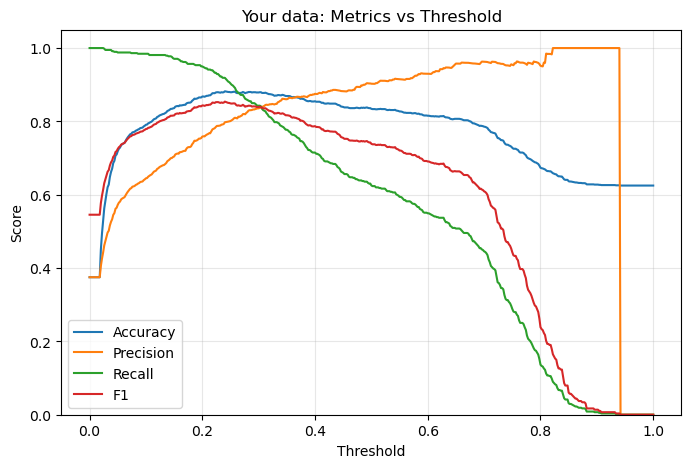

In [7]:
y = best_model.predict_proba(Z_test)[:, 1]

plot_metrics_vs_threshold(y_test, y, title="Your data: Metrics vs Threshold")

In [8]:
from sklearn.metrics import confusion_matrix

meta_prob = best_model.predict_proba(Z_test)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.130  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.6802395209580838 0.9810017271157168 0.8033946251768034
[[698 267]
 [ 11 568]]


In [9]:
from pathlib import Path

ARTS = Path("../../saved-models/kepler")
ARTS.mkdir(parents=True, exist_ok=True)

In [10]:
bundle1 = {
    "model": model,            
    "threshold": 0.5,              
}

joblib.dump(bundle1, ARTS / "kepler_simple_v1.pkl")
print("Saved →", ARTS / "kepler_simple_v1.pkl")

Saved → ../../saved-models/kepler/kepler_simple_v1.pkl
